#### Función de solapamiento: 

El objetivo de este fichero es documentar la función de solapamiento aplicado a los mapas objetivos. Para ello utilizaremos un mapa HGT como ejemplo.

shape:  (384, 416)


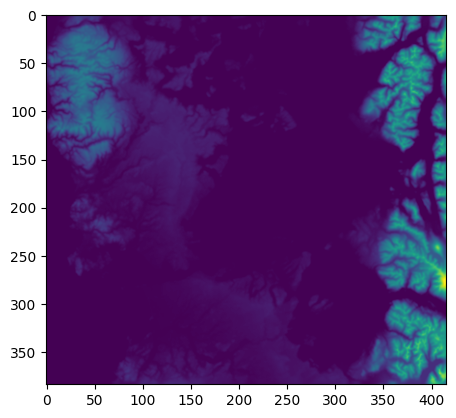

In [177]:
import matplotlib.pyplot as plt 
import numpy as np 


hgt = np.load("extra/files/wrfout_d05_2015-10-25_23:00:00.npy")[0,0]

print("shape: ", hgt.shape)   
plt.imshow(hgt)

#### 1. Idea 💡

La idea es simple, debido a que la longitud de los parches se conserva (longitud $(32,32)$), basta con simplemente desplazar este "molde cortador" de parches una cantidad constante para cumplir con este solapamiento, similar al comportamiento del  "kernel" y el "stride" dentro de las redes CNN. Trabajaremos con 3 desplazamientos diferentes: de 8, de 16 y de 24, con el fin de evaluar de manera completa el efecto de solapar parches en nuestro modelo Unet.

Para efectos de la zona objetivo, a ésta le integraremos un padding de tamaño $((32,32), (32,32))$ independiente del desplazamiento del molde. Utilizaremos dos tipos de padding: un padding "constante", que agrega valores 0, y un padding 'reflect', que reflecta los valores internos del borde al exterior. 

Un ejemplo de lo anterior se encuentre en la siguiente figura. Nuestra zona objetivo originalmente tiene dimensiones (384,416), una vez aplicado el padding, pasaría a tener dimensiones $(448, 480)$. Ahora bien, la elección del tamaño del padding es netamente para facilitar la construcción del futuro código, ya que dependiendo del desplazamiento escogido, el inicio de los cortes cambiará.

Tamaño del mapa original:  (384, 416)
Tamaño del mapa con padding reflect:  (448, 480)
Tamaño del mapa con padding same:  (448, 480)


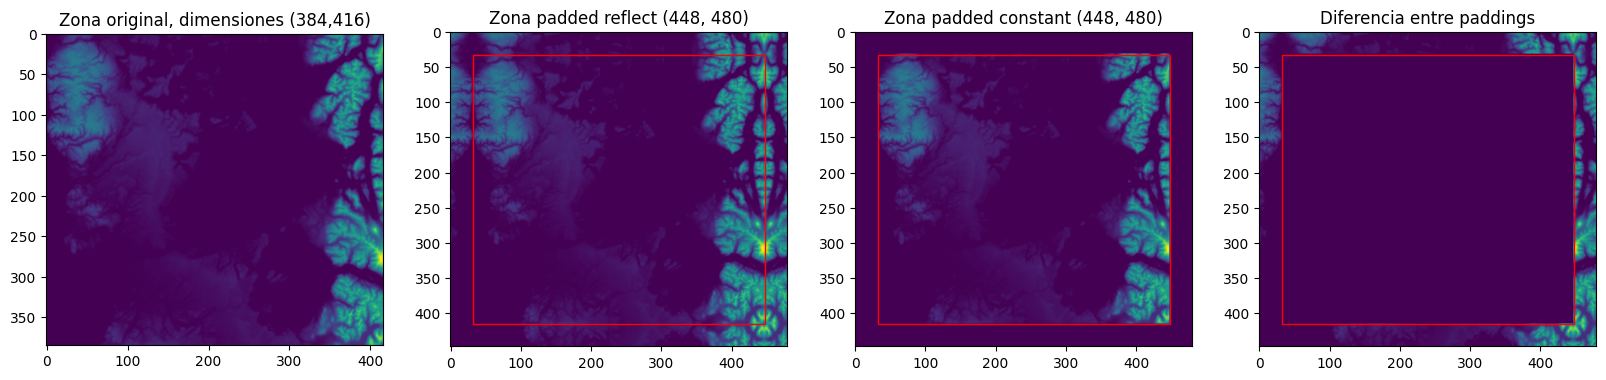

In [178]:
import matplotlib.patches as patches

hgt_reflect = np.pad(hgt, ((32, 32), (32, 32)), mode='reflect')
hgt_same    = np.pad(hgt, ((32, 32), (32, 32)), mode='constant')

print("Tamaño del mapa original: ", hgt.shape)
print("Tamaño del mapa con padding reflect: ", hgt_reflect.shape)
print("Tamaño del mapa con padding same: ", hgt_same.shape)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 10))

ax1.imshow(hgt, cmap='viridis')
ax1.set_title('Zona original, dimensiones (384,416)')

ax2.imshow(hgt_reflect, cmap='viridis')
rect2 = patches.Rectangle((32, 32), hgt.shape[1], hgt.shape[0], linewidth=1, edgecolor='r', facecolor='none')
ax2.add_patch(rect2)
ax2.set_title(f'Zona padded reflect {hgt_reflect.shape}')

ax3.imshow(hgt_same, cmap='viridis')
rect3 = patches.Rectangle((32, 32), hgt.shape[1], hgt.shape[0], linewidth=1, edgecolor='r', facecolor='none')
ax3.add_patch(rect3)
ax3.set_title(f'Zona padded constant {hgt_same.shape}')

ax4.imshow(hgt_reflect - hgt_same, cmap='viridis')
rect4 = patches.Rectangle((32, 32), hgt.shape[1], hgt.shape[0], linewidth=1, edgecolor='r', facecolor='none')
ax4.add_patch(rect4)
ax4.set_title(f'Diferencia entre paddings')

plt.show()

#### 2. Límites de corte: 

A excepción del desplazamiento de tamaño 24, los desplazamientos restantes: $8$ y $16$, al ser ambos divisores de 32, crearán un mallado simétrico en nuestra zona padded. Esta falta de simetría en uno de nuestros desplazamientos sería relevante si nuestra prioridad en las predicciones no solo fuera la zona interna del mapa sino también los bordes, por lo cual no forzaremos esta característica para este desplazamiento. 

El inicio del proceso de corte vendrá dado por el tamaño del solapamiento, es decir, si escogemos 8 como desplazamiento, el primer corte (o también considerado como borde exterior), será en el valor 8 de la zona padded. Luego solo resta ir moviendose 8 espacios.

In [179]:
def calcular_cortes(solap=int, shape_padded=(448,480)):
    ''' Función que calcula la posición de los cortes verticales y horizontales
        considerando solapamiento.
    input:
        solap: [int] Tamaño del desplazamiento. Las opciones son 8,16 y 24
        shape_padded [tupla]: Tamaño de la zona post padding. Valor default igual 
        a padding ((32,32),(32,32))
    return: 
        cortes_x, cortes_y [list] Lista de tuplas pares que contienen la posición de 
        cortado de los parches en ambas direcciones.
    ''' 
    cortes_x = np.arange(solap, shape_padded[0], solap)
    cortes_y = np.arange(solap, shape_padded[1], solap)
    cortes_y = [(i, i + 32) for i in cortes_y if i+32 < shape_padded[1]] 
    cortes_x = [(i, i + 32) for i in cortes_x if i+32 < shape_padded[0]]

    return cortes_x, cortes_y

cortes_x, cortes_y = calcular_cortes(solap=8)
print("Ejemplo de la posición de los cortes verticales: ", cortes_y[:3], "...", cortes_y[-3:])
print("Ejemplo de la posición de los cortes horizontales: ", cortes_x[:3], "...", cortes_x[-3:])

Ejemplo de la posición de los cortes verticales:  [(8, 40), (16, 48), (24, 56)] ... [(424, 456), (432, 464), (440, 472)]
Ejemplo de la posición de los cortes horizontales:  [(8, 40), (16, 48), (24, 56)] ... [(392, 424), (400, 432), (408, 440)]


#### Visualización de los cortes

Para visualizar los cortes, utilizaremos "rectángulos" que representarán a un parche cortado. Ahora bien, debido a que estamos trabajando con parches solapados, los contornos de estos rectángulos se irán superponiendo, produciendo la siguiente figura. 

Nota: Se visualiza la esquina superior izquierda de cada parche. Los colores fueron alternados para facilitar la visualización.

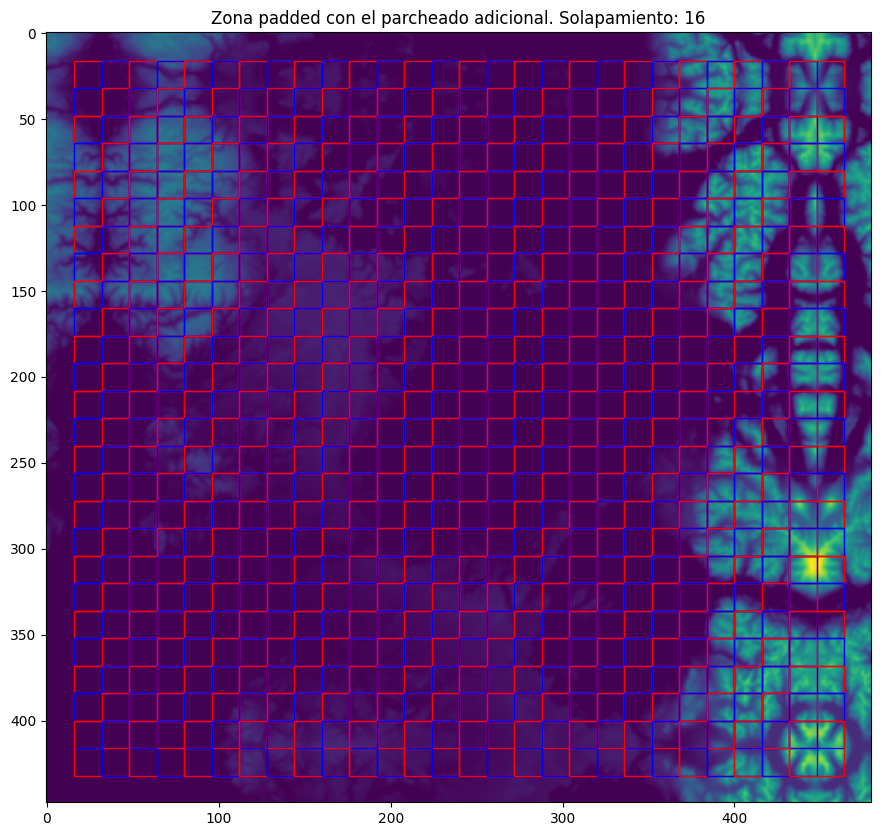

In [180]:
solap=16
cortes_x, cortes_y = calcular_cortes(solap=solap)

color = ["red", "blue"]
fig, (ax1) = plt.subplots(1, 1, figsize=(20, 10))

### Gráfico 2: Nuevo parcheado - Zona padded  
ax1.imshow(hgt_reflect, cmap='viridis')
ax1.set_title(f'Zona padded con el parcheado adicional. Solapamiento: {solap}')
k=0
for j in cortes_y: #lineas horizontales
    for i in cortes_x:
        rect=patches.Rectangle((j[0], i[0]), 32, 32, linewidth=1, edgecolor=color[k % 2], facecolor="None") 
        ax1.add_patch(rect)
        k += 1

#### 3. Proceso de cortado

El proceso de cortado se hará mediante una simple indexación del tensor que contiene al mapa. Para ello, utilizaremos los cortes creados previamente como límites de cortado:

Nota: Resta adaptar esta función para el tensor que contendrá a todos los mapas.

In [183]:
hgt_padded = hgt_reflect
stack = np.zeros( (1,32,32))

for i in cortes_x: 
    for j in cortes_y:
        hgt_ij = np.expand_dims ( hgt_padded[ i[0]: i[1], j[0]:j[1]], axis=0)
        stack = np.concatenate((stack, hgt_ij), axis=0)
stack = stack[1:]
print("Dimensión del vector stack: ", stack.shape)

Dimensión del vector stack:  (675, 32, 32)


#### 4. Proceso de reconstrucción

La idea es reconstruir los mapas originales (considerando el solapamiento aplicado) para comprobar que el proceso de cortado fue hecho correctamente. Como el solapamiento utilizado para ejemplificar es de 16, en caso de querer reconstruir el mapa completo, tenemos que tener en cuenta dos cosas: 
- (1) De manera horizontal, parche por medio serán independientes y por ende, pasarán a formar un mismo mapa. Para resolver esto, basta con utilizar la indexación [::2] propia de los tensores.
- (2) De manera vertical, cada 14 parches pasarán a formar parte de un mismo mapa. Para resolver esto, crearemos una lista de índices personalizadas que contenga los 14 primeros índices, luego se salte los 14 siguientes y vuelva tomar otros 14, y así sucesivamente. 

Para atender el primer punto, extraeremos cada 27 parches (correspondientes a una misma fila solapada) y le aplicaremos la indexación [::2]

In [184]:
stacker = np.zeros((1,32,32))
for i in range(12*13): 
    stack_14_elem = stack[27*i : 27*(i+1)] #cada 27 elementos (una fila)
    stack_cada_2 = stack_14_elem[::2] #excluyo uno por medio
    stacker = np.concatenate((stacker, stack_cada_2), axis=0)
stacker=stacker[1:]
print("Dimensión del stack modificado dirección horizontal: ", stacker.shape)

Dimensión del stack modificado dirección horizontal:  (350, 32, 32)


Para atender el segundo punto, creamos esta lista de índices personalizada sin pasarnos del máximo y reindexamos nuestro stack anteriormente creado:

In [186]:
take = 14 #cuántos elementos tomamos
skip = 14 #cuántos elementos nos saltamos 

n = stacker.shape[0]
indices = np.concatenate([np.arange(i, i + take) for i in range(0, n, take + skip) if i + take <= n])

#re-indexación del stack
subset = stacker[indices]
print("Dimensión del stack modificado dirección vertical: ", subset.shape)

Dimensión del stack modificado dirección vertical:  (182, 32, 32)


Para visualizar el mapa construído, creamos un vector de ceros con las dimensiones del nuevo mapa: $(13*32, 14*32)$, e iremos reemplazando sus valores con los parches almacenados en el stack de izquierda a derecha y de arriba para abajo.

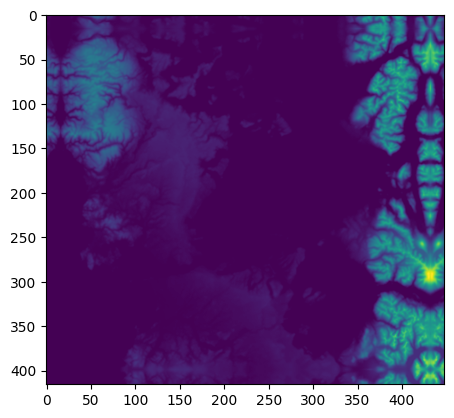

In [187]:
reconstructed_map = np.zeros((416, 448))
index=0
for i in range(13):  # 13 filas
    for j in range(14):  # 14 columnas
        reconstructed_map[i*32:(i+1)*32, j*32:(j+1)*32] = subset[index]
        index += 1

plt.imshow(reconstructed_map) 

Finalmente, restamos los valores del mapa reconstruído con el mapa padded para comprobar que la diferencia entre ellos es nula y por ende, el vector reconstruído es el mismo que el original (versión padded):

In [189]:
hgt_padded_slope_16 = hgt_reflect[16:, 16:] #excluímos los primeros 16 valores tanto en filas como columnas
hgt_target = hgt_padded_slope_16[:-16, :-16] #excluímos los últimos 16 valores tanto en filas como columnas

if np.sum( hgt_target - reconstructed_map ) == 0:
    print("Mapa reconstruído igual al mapa target")

Mapa reconstruído igual al mapa target


Repetiremos este mismo proceso pero para los parches excluídos:

In [195]:
stacker = np.zeros((1,32,32))
for i in range(12*13): 
    stack_14_elem = stack[27*i : 27*(i+1)] #cada 27 elementos (una fila)
    stack_cada_2 = stack_14_elem[1::2] #excluyo uno por medio, comenzando por el segundo término
    stacker = np.concatenate((stacker, stack_cada_2), axis=0)
stacker=stacker[1:]
print("Dimensión del stack modificado dirección horizontal: ", stacker.shape)


take = 13; skip = 13

n = stacker.shape[0]
indices = np.concatenate([np.arange(i, i + take) for i in range(13, n, take + skip) if i + take <= n])
subset = stacker[indices]

print("Dimensión del stack modificado dirección vertical: ", subset.shape)

Dimensión del stack modificado dirección horizontal:  (325, 32, 32)
Dimensión del stack modificado dirección vertical:  (156, 32, 32)


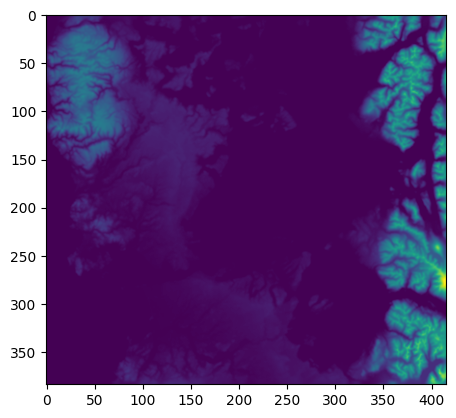

In [198]:
reconstructed_map = np.zeros((12*32, 13*32))
index=0
for i in range(12):  # 13 filas
    for j in range(13):  # 14 columnas
        reconstructed_map[i*32:(i+1)*32, j*32:(j+1)*32] = subset[index]
        index += 1

plt.imshow(reconstructed_map) 

In [199]:
hgt_padded_slope_16 = hgt_reflect[32:, 32:] #excluímos los primeros 16 valores tanto en filas como columnas
hgt_target = hgt_padded_slope_16[:-32, :-32] #excluímos los últimos 16 valores tanto en filas como columnas

if np.sum( hgt_target - reconstructed_map ) == 0:
    print("Mapa reconstruído igual al mapa target")

Mapa reconstruído igual al mapa target
